In [1]:
!pip install transformers 4.9.0
!pip install datasets transformers[sentencepiece]

ERROR: Could not find a version that satisfies the requirement 4.9.0 (from versions: none)
ERROR: No matching distribution found for 4.9.0


In [2]:
from __future__ import print_function  
import psutil
print(psutil.__version__)

5.9.1


In [3]:
CUDA_LAUNCH_BLOCKING=1

# Preprocessing

In [10]:
import torch, random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

f1_micro_graphical = 0
f1_macro_graphical = 0
acc_graphical = 0

f1_micro_textual = 0
f1_macro_textual = 0
acc_textual = 0

f1_micro_ensemble = 0
f1_macro_ensemble = 0
acc_ensemble = 0
first_df = pd.read_json('../input/last-3600/last_3660.json',encoding='utf-8')
# first_df = pd.read_csv('../input/inf-4500/inf_4500.txt', sep="\t",encoding='utf-16')
# first_df.drop(first_df.index[[0]], inplace=True)
# first_df.drop(first_df.columns[[10,11,12,13,14]], axis=1, inplace=True)

first_df.drop(first_df.index[[0]], inplace=True)
print(len(first_df))
first_df.head(3)
random.seed(0)

3662


In [11]:
columns = ['content', 'background','textcolor','font', 'label']
df = pd.DataFrame(first_df, columns=columns)
df.columns = ['content', 'background','textcolor','font', 'label']
df

,content,background,textcolor,font,label
1,عباس \nامیر انتظام شیرمردی در وادی ایران نوین...,pattern_f,blue,iransans,monasebat
2,صدا و سیما. شبکه خبر صدا و سیما؛ شبکه العالم,default,white,iphone,siyasi
3,که تو دنیای منی سبز بمانی همه عمر\n\n ...,default,white,suls,monasebat
4,تخفیف ویژه کلاسهای خصوصی ارایشگری ظرفیت فقط 4...,base_background_gd,red,dastnevis,tablighat va business
5,چقدر قشنگه یه نفر تو زندگیت باشه که هم عشقت با...,default,black,dastnevis,asheqane
...,...,...,...,...,...
3658,شنیده‌ها درباره حمله به کاروان حزب الله\n\nخبر...,default,default,sahel,siyasi
3659,یه سری پس زمینه اینجوری هم داره واسه چس ناله ه...,pattern_g,default,pooya,majazi
3660,دوستان صبر ایوب خواستن، بعد از ایام عذا پخش می...,pattern_o,white,shabnam,monasebat
3661,احتمالا زمان fit کردن مدل یادگیری آرگومان verb...,yellow_background,black,sahel,IT


In [5]:
df['label'].value_counts()

monasebat                359
tablighat va business    321
siyasi                   311
nasihat va sokhan        253
pezeshki                 213
asheqane                 204
elmi                     175
mazhabi                  174
majazi                   172
zibayi                   167
ejtemayi                 162
IT                       154
sher va adabiyat         131
varzeshi                 124
melk o maskan            123
angizeshi                118
tourist va amaken         91
dars va daneshgah         81
ashpazi                   71
eqtesadi                  65
tanz                      65
greet                     63
honar                     31
agahi                     27
Name: label, dtype: int64

In [7]:
df = df.groupby('label').filter(lambda x : len(x)>80)
print(len(df['label'].value_counts()))

18


In [8]:
# remove_list = ['angizeshi',  'sher va adabiyat', 'majazi', 'nasihat va sokhan', 'dars va daneshgah', 'honar eqtesadi','tanz','agahi','greet', 'asheqane', 'honar', 'mazhabi', 'eqtesadi']
# remove_list = ['dars va daneshgah',  'agahi', 'tanz']
# for i in remove_list:
#     df = df[df.label != i]

In [10]:
class_num = len(df['label'].value_counts())
class_num

18

Text(0, 0.5, 'Frequency')

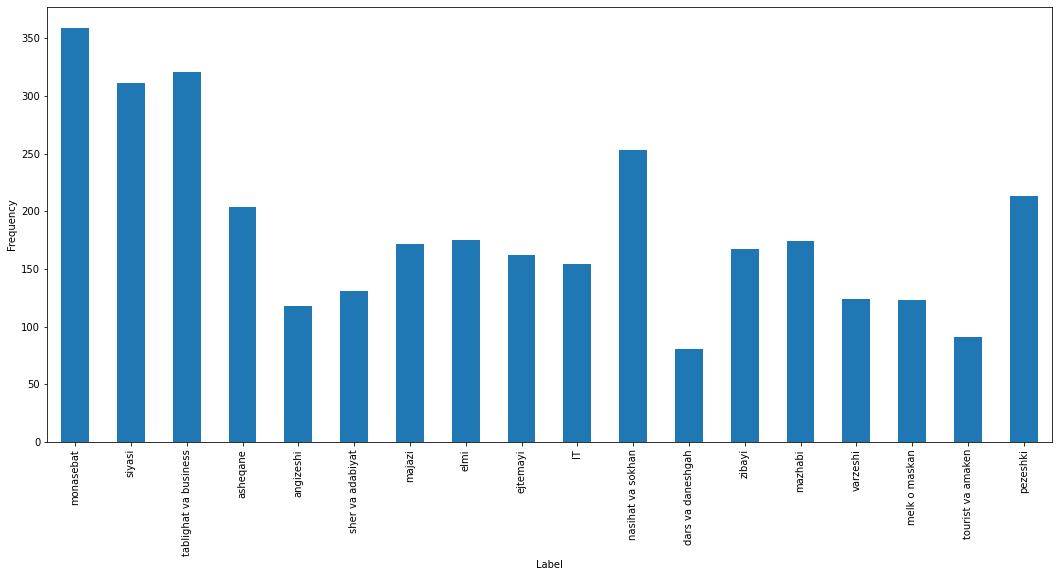

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 8]
# df['label'].value_counts(sort=False).plot.bar()


df['label'].value_counts(sort=False).plot(kind="bar")
plt.xticks( horizontalalignment="center")
plt.xlabel("Label")
plt.ylabel("Frequency")



In [10]:
def convert_to_numeric(col):
  possible_labels = df[col].unique()
  col_dict = {}
  for index, possible_label in enumerate(possible_labels):
      col_dict[possible_label] = index
  return col_dict

df['background'] = df.background.replace(convert_to_numeric('background'))
df['textcolor'] = df.textcolor.replace(convert_to_numeric('textcolor'))
df['font'] = df.font.replace(convert_to_numeric('font'))

possible_labels = df.label.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    
df['label'] = df.label.replace(label_dict)
df

,content,background,textcolor,font,label
1,عباس \nامیر انتظام شیرمردی در وادی ایران نوین...,0,0,0,0
2,صدا و سیما. شبکه خبر صدا و سیما؛ شبکه العالم,1,1,1,1
3,که تو دنیای منی سبز بمانی همه عمر\n\n ...,1,1,2,0
4,تخفیف ویژه کلاسهای خصوصی ارایشگری ظرفیت فقط 4...,2,2,3,2
5,چقدر قشنگه یه نفر تو زندگیت باشه که هم عشقت با...,1,3,3,3
...,...,...,...,...,...
3658,شنیده‌ها درباره حمله به کاروان حزب الله\n\nخبر...,1,4,9,1
3659,یه سری پس زمینه اینجوری هم داره واسه چس ناله ه...,32,4,6,6
3660,دوستان صبر ایوب خواستن، بعد از ایام عذا پخش می...,28,1,13,0
3661,احتمالا زمان fit کردن مدل یادگیری آرگومان verb...,11,3,9,9


# Graphical Classification

In [11]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.80*len(df)), int(.90*len(df))])

print(len(df_train),len(df_val), len(df_test))

2666 333 334


In [12]:
import torch
import numpy as np
from transformers import BertTokenizer
import torch.nn.functional as Fun

class GraphicalDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels =[label for label in df['label']]
        self.back = [g for g in df['background']]
        self.textcolor = [g for g in df['textcolor']]
        self.font = [g for g in df['font']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_back(self, idx):
        return self.back[idx]
 
    def get_batch_textcolor(self, idx):
        return self.textcolor[idx]

    def get_batch_font(self, idx):
        return self.font[idx]
    
    def __getitem__(self, idx):

        batch_back  = self.get_batch_back(idx)
        batch_textcolor  = self.get_batch_textcolor(idx)
        batch_font  = self.get_batch_font(idx)
        batch_y = self.get_batch_labels(idx)

        max_value_back = np.max(np.max(df['background'].unique()))
        values_tensor = torch.tensor(batch_back)
        output_back = Fun.one_hot(values_tensor, num_classes = max_value_back+1)
        
        max_value_textcolor = np.max(np.max(df['textcolor'].unique()))
        values_tensor = torch.tensor(batch_textcolor)
        output_textcolor = Fun.one_hot(values_tensor, num_classes = max_value_textcolor+1)
        
        max_value_font = np.max(np.max(df['font'].unique()))
        values_tensor = torch.tensor(batch_font)
        output_font = Fun.one_hot(values_tensor, num_classes = max_value_font+1)
        
        values_tensor1 = torch.tensor((batch_y))
#         batch_y = Fun.one_hot(values_tensor1, num_classes = 25)
        return output_back, output_textcolor, output_font, batch_y


In [13]:
from torch import nn
from transformers import BertModel,AutoModelForMaskedLM,AutoModel

class GraphicalClassifier(nn.Module):

    def __init__(self):

        super(GraphicalClassifier, self).__init__()
        
        seed = 0
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
      
        self.fc_back = nn.Linear(36,100)
        self.fc_textcolor = nn.Linear(12,100)
        self.fc_font = nn.Linear(16,100)
        
        
        self.fc_hidden_back = nn.Linear(100,25)
        self.fc_hidden_textcolor = nn.Linear(100,20)
        self.fc_hiddent_font = nn.Linear(100,22)
        
        self.fc_tab = nn.Linear(25+20+22, class_num)
        self.relu = nn.ReLU()

    def forward(self, input_back, input_textcolor, input_font):

        mlp_back = self.relu(self.fc_hidden_back(self.relu(self.fc_back(input_back.float()))))
        mlp_textcolor = self.relu(self.fc_hidden_textcolor(self.relu(self.fc_textcolor(input_textcolor.float()))))
        mlp_font = self.relu(self.fc_hiddent_font(self.relu(self.fc_font(input_font.float()))))
        concat_tab = torch.cat(
             (mlp_back.float(),
              mlp_textcolor.float(),
              mlp_font.float()),1)
        
        mlp = self.fc_tab(concat_tab)
        return mlp

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = 0.5

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import f1_score ,precision_score, recall_score

def train(model, train_data, val_data, learning_rate, epochs, batch_size):
    
    train, val = GraphicalDataset(train_data), GraphicalDataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    early_stopper = EarlyStopper(patience=4, min_delta=0.001)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            
            for  input_back, input_textcolor, input_font, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                back = input_back.to(device)
                textcolor = input_textcolor.to(device)
                font = input_font.to(device)
                train_label = train_label.to(device)

                output = model(back, textcolor, font)
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                    
            total_acc_val = 0
            total_loss_val = 0
            
            with torch.no_grad():
            
                for val_back, val_textcolor, val_font, val_label in val_dataloader:

                    back = val_back.to(device)
                    textcolor = val_textcolor.to(device)
                    font = val_font.to(device)

                    output = model(back, textcolor, font)
                    val_label = val_label.to(device)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
                   
            if early_stopper.early_stop(total_loss_val / len(val_data)): 
                print("Early Stopped.")
                break
                
            print(
                 f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                 | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                 | Val Loss: {total_loss_val / len(val_data): .3f} \
                 | Val Accuracy: {total_acc_val / len(val_data): .3f}')

           
    
EPOCHS= 200
model = GraphicalClassifier()
LR = 4e-4

batch_size = 8
              
train(model, df_train, df_val, LR, EPOCHS, batch_size)

100%|██████████| 334/334 [00:02<00:00, 117.00it/s]


Epochs: 1 | Train Loss:  0.353                  | Train Accuracy:  0.102                  | Val Loss:  0.346                  | Val Accuracy:  0.150


100%|██████████| 334/334 [00:01<00:00, 177.86it/s]


Epochs: 2 | Train Loss:  0.336                  | Train Accuracy:  0.183                  | Val Loss:  0.329                  | Val Accuracy:  0.225


100%|██████████| 334/334 [00:01<00:00, 183.17it/s]


Epochs: 3 | Train Loss:  0.320                  | Train Accuracy:  0.219                  | Val Loss:  0.317                  | Val Accuracy:  0.228


100%|██████████| 334/334 [00:02<00:00, 149.99it/s]


Epochs: 4 | Train Loss:  0.310                  | Train Accuracy:  0.232                  | Val Loss:  0.311                  | Val Accuracy:  0.228


100%|██████████| 334/334 [00:01<00:00, 179.64it/s]


Epochs: 5 | Train Loss:  0.305                  | Train Accuracy:  0.240                  | Val Loss:  0.308                  | Val Accuracy:  0.228


100%|██████████| 334/334 [00:01<00:00, 180.35it/s]


Epochs: 6 | Train Loss:  0.301                  | Train Accuracy:  0.253                  | Val Loss:  0.306                  | Val Accuracy:  0.222


100%|██████████| 334/334 [00:01<00:00, 184.42it/s]


Epochs: 7 | Train Loss:  0.298                  | Train Accuracy:  0.265                  | Val Loss:  0.304                  | Val Accuracy:  0.237


100%|██████████| 334/334 [00:01<00:00, 181.72it/s]


Epochs: 8 | Train Loss:  0.296                  | Train Accuracy:  0.273                  | Val Loss:  0.303                  | Val Accuracy:  0.243


100%|██████████| 334/334 [00:02<00:00, 163.67it/s]


Epochs: 9 | Train Loss:  0.294                  | Train Accuracy:  0.276                  | Val Loss:  0.303                  | Val Accuracy:  0.249


100%|██████████| 334/334 [00:01<00:00, 181.66it/s]


Epochs: 10 | Train Loss:  0.292                  | Train Accuracy:  0.280                  | Val Loss:  0.303                  | Val Accuracy:  0.243


100%|██████████| 334/334 [00:02<00:00, 156.92it/s]


Epochs: 11 | Train Loss:  0.290                  | Train Accuracy:  0.284                  | Val Loss:  0.303                  | Val Accuracy:  0.243


100%|██████████| 334/334 [00:02<00:00, 162.85it/s]


Epochs: 12 | Train Loss:  0.289                  | Train Accuracy:  0.290                  | Val Loss:  0.302                  | Val Accuracy:  0.243


100%|██████████| 334/334 [00:01<00:00, 182.20it/s]


Epochs: 13 | Train Loss:  0.288                  | Train Accuracy:  0.293                  | Val Loss:  0.302                  | Val Accuracy:  0.249


100%|██████████| 334/334 [00:01<00:00, 170.34it/s]


Epochs: 14 | Train Loss:  0.287                  | Train Accuracy:  0.297                  | Val Loss:  0.302                  | Val Accuracy:  0.258


100%|██████████| 334/334 [00:01<00:00, 173.02it/s]


Epochs: 15 | Train Loss:  0.286                  | Train Accuracy:  0.299                  | Val Loss:  0.302                  | Val Accuracy:  0.261


100%|██████████| 334/334 [00:01<00:00, 181.24it/s]


Epochs: 16 | Train Loss:  0.285                  | Train Accuracy:  0.300                  | Val Loss:  0.303                  | Val Accuracy:  0.264


100%|██████████| 334/334 [00:01<00:00, 178.64it/s]


Epochs: 17 | Train Loss:  0.284                  | Train Accuracy:  0.302                  | Val Loss:  0.303                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:01<00:00, 179.82it/s]


Epochs: 18 | Train Loss:  0.284                  | Train Accuracy:  0.303                  | Val Loss:  0.303                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:01<00:00, 175.11it/s]


Epochs: 19 | Train Loss:  0.283                  | Train Accuracy:  0.305                  | Val Loss:  0.303                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:02<00:00, 157.08it/s]


Epochs: 20 | Train Loss:  0.282                  | Train Accuracy:  0.303                  | Val Loss:  0.303                  | Val Accuracy:  0.273


100%|██████████| 334/334 [00:01<00:00, 177.86it/s]


Epochs: 21 | Train Loss:  0.282                  | Train Accuracy:  0.304                  | Val Loss:  0.303                  | Val Accuracy:  0.273


100%|██████████| 334/334 [00:01<00:00, 175.20it/s]


Epochs: 22 | Train Loss:  0.281                  | Train Accuracy:  0.305                  | Val Loss:  0.303                  | Val Accuracy:  0.270


100%|██████████| 334/334 [00:01<00:00, 183.99it/s]


Epochs: 23 | Train Loss:  0.281                  | Train Accuracy:  0.305                  | Val Loss:  0.303                  | Val Accuracy:  0.270


100%|██████████| 334/334 [00:01<00:00, 177.71it/s]


Epochs: 24 | Train Loss:  0.280                  | Train Accuracy:  0.304                  | Val Loss:  0.303                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:02<00:00, 156.53it/s]


Epochs: 25 | Train Loss:  0.280                  | Train Accuracy:  0.306                  | Val Loss:  0.303                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:02<00:00, 166.66it/s]


Epochs: 26 | Train Loss:  0.280                  | Train Accuracy:  0.305                  | Val Loss:  0.303                  | Val Accuracy:  0.264


100%|██████████| 334/334 [00:02<00:00, 162.87it/s]


Epochs: 27 | Train Loss:  0.279                  | Train Accuracy:  0.306                  | Val Loss:  0.303                  | Val Accuracy:  0.264


100%|██████████| 334/334 [00:01<00:00, 181.77it/s]


Epochs: 28 | Train Loss:  0.279                  | Train Accuracy:  0.309                  | Val Loss:  0.304                  | Val Accuracy:  0.264


100%|██████████| 334/334 [00:01<00:00, 182.52it/s]


Epochs: 29 | Train Loss:  0.278                  | Train Accuracy:  0.309                  | Val Loss:  0.304                  | Val Accuracy:  0.267


100%|██████████| 334/334 [00:02<00:00, 155.50it/s]


Early Stopped.


In [18]:
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    test = GraphicalDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    outputs = []
    labels = []
    with torch.no_grad():
         
        for test_back, test_textcolor, test_font, test_label in test_dataloader:
        
            test_label = test_label.to(device)
            back = test_back.to(device)
            textcolor = test_textcolor.to(device)
            font = test_font.to(device)

            output =  model(back, textcolor, font)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            for i in output.argmax(dim=1).tolist():
                outputs.append(i)
            for i in test_label.cpu():
                labels.append(i)
    global f1_micro_graphical 
    global f1_macro_graphical 
    global acc_graphical 
    acc_graphical = total_acc_test / len(test_data)
    f1_macro_graphical = f1_score(outputs, labels, average='macro')
    f1_micro_graphical = f1_score(outputs, labels, average='micro')
                       
    print(f'Test Accuracy: {acc_graphical}')
    print('F1-Score macro: ',f1_macro_graphical)
    print('F1-Score micro: ',f1_micro_graphical)
    print('precision', precision_score(outputs, labels, average='weighted'))
    print('recall', recall_score(outputs, labels, average='weighted'))

    
    
    arr = []
    for i in range(class_num):
        arr.append(str(i))
    print(classification_report(labels, outputs, target_names=arr))

    
evaluate(model, df_test)

label_dict

Test Accuracy: 0.23652694610778444
F1-Score macro:  0.18828670075548443
F1-Score micro:  0.23652694610778444
precision 0.3145331144850527
recall 0.23652694610778444
              precision    recall  f1-score   support

           0       0.14      0.24      0.17        34
           1       0.27      0.48      0.35        25
           2       0.20      0.21      0.21        33
           3       0.10      0.15      0.12        20
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00        15
           7       0.57      0.57      0.57        23
           8       0.31      0.45      0.37        20
           9       0.35      0.56      0.43        16
          10       0.20      0.15      0.17        26
          11       0.00      0.00      0.00         4
          12       0.07      0.08      0.07        12
          13       0.00      0.00      0.00        23
          14       0.32 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: Undefine

{'monasebat': 0,
 'siyasi': 1,
 'tablighat va business': 2,
 'asheqane': 3,
 'angizeshi': 4,
 'sher va adabiyat': 5,
 'majazi': 6,
 'elmi': 7,
 'ejtemayi': 8,
 'IT': 9,
 'nasihat va sokhan': 10,
 'dars va daneshgah': 11,
 'zibayi': 12,
 'mazhabi': 13,
 'varzeshi': 14,
 'melk o maskan': 15,
 'tourist va amaken': 16,
 'pezeshki': 17}

In [19]:
filepath = "graphical"
torch.save(model.state_dict(), "graphical")


In [20]:
model.load_state_dict(torch.load(filepath))
model.eval()

GraphicalClassifier(
  (fc_back): Linear(in_features=36, out_features=100, bias=True)
  (fc_textcolor): Linear(in_features=12, out_features=100, bias=True)
  (fc_font): Linear(in_features=16, out_features=100, bias=True)
  (fc_hidden_back): Linear(in_features=100, out_features=25, bias=True)
  (fc_hidden_textcolor): Linear(in_features=100, out_features=20, bias=True)
  (fc_hiddent_font): Linear(in_features=100, out_features=22, bias=True)
  (fc_tab): Linear(in_features=67, out_features=18, bias=True)
  (relu): ReLU()
)

# Text Classification

In [21]:
import torch
import numpy as np
from transformers import BertTokenizer
import torch.nn.functional as Fun
# check_point= "bert-base-uncased"
check_point= "sentence-transformers/LaBSE"
# check_point="HooshvareLab/bert-base-parsbert-uncased"
tokenizer = BertTokenizer.from_pretrained(check_point)
labels = label_dict

class TextDataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels =[label for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['content']]
                                
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    
    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


Downloading:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

In [22]:
from torch import nn
from transformers import BertModel,AutoModelForMaskedLM,AutoModel

class TextClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(TextClassifier, self).__init__()
        seed = 0
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        self.bert =BertModel.from_pretrained(check_point)
        self.dropout = nn.Dropout(dropout)
        self.fc1  = nn.Linear(768, class_num)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
        
    def forward(self, input_id, mask):
        
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        fc1 = self.fc1(dropout_output)
        # final_layer = self.softmax(fc1)
        
        return self.relu(fc1)

In [23]:
train, val, test = TextDataset(df_train), TextDataset(df_val), TextDataset(df_test)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [24]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs, batch_size):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    early_stopper = EarlyStopper(patience=2, min_delta=0.01)
   
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            
            for train_input, train_label in tqdm(train_dataloader):

                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                train_label = train_label.to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            total_acc_val = 0
            total_loss_val = 0
            
            with torch.no_grad():
            
                for val_input, val_label in val_dataloader:
                   
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    val_label = val_label.to(device)
                    output = model(input_id, mask)
                    
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                 | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                 | Val Loss: {total_loss_val / len(df_val): .3f} \
                 | Val Accuracy: {total_acc_val / len(df_val): .3f}')
            
            if early_stopper.early_stop(total_loss_val / len(val_data)): 
                print("Early Stopped.")
                break

EPOCHS = 10
model = TextClassifier()
LR = 5e-5
batch_size = 8
              
train(model, df_train, df_val, LR, EPOCHS, batch_size)

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

100%|██████████| 334/334 [02:40<00:00,  2.08it/s]


Epochs: 1 | Train Loss:  0.180                  | Train Accuracy:  0.610                  | Val Loss:  0.102                  | Val Accuracy:  0.787


100%|██████████| 334/334 [02:40<00:00,  2.08it/s]


Epochs: 2 | Train Loss:  0.066                  | Train Accuracy:  0.855                  | Val Loss:  0.087                  | Val Accuracy:  0.811


100%|██████████| 334/334 [02:40<00:00,  2.08it/s]


Epochs: 3 | Train Loss:  0.036                  | Train Accuracy:  0.925                  | Val Loss:  0.106                  | Val Accuracy:  0.781


100%|██████████| 334/334 [02:40<00:00,  2.08it/s]


Epochs: 4 | Train Loss:  0.020                  | Train Accuracy:  0.963                  | Val Loss:  0.095                  | Val Accuracy:  0.820


100%|██████████| 334/334 [02:40<00:00,  2.08it/s]


Epochs: 5 | Train Loss:  0.013                  | Train Accuracy:  0.977                  | Val Loss:  0.124                  | Val Accuracy:  0.775
Early Stopped.


In [29]:
def evaluate(model):
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    outputs = []
    labels = []
    with torch.no_grad():
         
        for test_input, test_label in test_dataloader:
        
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output =  model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            for i in output.argmax(dim=1).tolist():
                outputs.append(i)
            for i in test_label.cpu():
                labels.append(i)
                
    global f1_micro_textual 
    global f1_macro_textual 
    global acc_textual 
    acc_textual = total_acc_test / len(df_test)
    f1_macro_textual = f1_score(outputs, labels, average='macro')
    f1_micro_textual = f1_score(outputs, labels, average='micro')
    print(f'Test Accuracy: {acc_textual}')
    print('F1-Score macro: ',f1_macro_textual )
    print('F1-Score micro: ',f1_micro_textual )
    print('precision', precision_score(outputs, labels, average='weighted'))
    print('recall', recall_score(outputs, labels, average='weighted'))
    arr = []
    for i in range(class_num):
        arr.append(str(i))
    print(classification_report(labels, outputs, target_names=arr))

    
evaluate(model)

Test Accuracy: 0.7125748502994012
F1-Score macro:  0.7300719597574302
F1-Score micro:  0.7125748502994012
precision 0.7410118015900008
recall 0.7125748502994012
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.84      0.84      0.84        25
           2       0.92      0.73      0.81        33
           3       0.80      0.60      0.69        20
           4       0.44      0.44      0.44         9
           5       0.77      0.62      0.69        16
           6       0.65      0.87      0.74        15
           7       0.92      0.48      0.63        23
           8       0.25      0.75      0.37        20
           9       0.87      0.81      0.84        16
          10       0.55      0.62      0.58        26
          11       1.00      0.75      0.86         4
          12       0.92      0.92      0.92        12
          13       1.00      0.43      0.61        23
          14       0.92     

In [30]:
filepath ="text"
torch.save(model.state_dict(), filepath)

In [31]:
model.load_state_dict(torch.load(filepath))
# model

<All keys matched successfully>

# Ensemble

In [32]:
import torch
import numpy as np
from transformers import BertTokenizer
import torch.nn.functional as Fun
tokenizer = BertTokenizer.from_pretrained(check_point)
labels = label_dict

class EnsembleDataset(torch.utils.data.Dataset):

    def __init__(self, df):


        self.labels =[label for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 300, truncation=True,
                                return_tensors="pt") for text in df['content']]
        self.back = [g for g in df['background']]
        self.textcolor = [g for g in df['textcolor']]
        self.font = [g for g in df['font']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def get_batch_back(self, idx):
        return self.back[idx]
 
    def get_batch_textcolor(self, idx):
        return self.textcolor[idx]

    def get_batch_font(self, idx):
        return self.font[idx]
    
    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_back  = self.get_batch_back(idx)
        batch_textcolor  = self.get_batch_textcolor(idx)
        batch_font  = self.get_batch_font(idx)
        batch_y = self.get_batch_labels(idx)

        max_value_back = np.max(np.max(df['background'].unique()))
        values_tensor = torch.tensor(batch_back)
        output_back = Fun.one_hot(values_tensor, num_classes = max_value_back+1)
        
        max_value_textcolor = np.max(np.max(df['textcolor'].unique()))
        values_tensor = torch.tensor(batch_textcolor)
        output_textcolor = Fun.one_hot(values_tensor, num_classes = max_value_textcolor+1)
        
        max_value_font = np.max(np.max(df['font'].unique()))
        values_tensor = torch.tensor(batch_font)
        output_font = Fun.one_hot(values_tensor, num_classes = max_value_font+1)
        
        return batch_texts, output_back, output_textcolor, output_font, batch_y


In [33]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        
        super(MyEnsemble, self).__init__()
        seed = 0
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            
        self.modelA = modelA
        self.modelB = modelB
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(class_num*2, class_num)
        self.linear2 = nn.Linear(class_num,   class_num)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,input_id, mask, back, textcolor, font):
        x1 = self.modelA(back, textcolor, font)
        x2 = self.modelB(input_id, mask)
        x = torch.cat((x1, x2), dim=1)
        x = self.linear1(x)
#         x = self.relu(x)
        # x = self.linear2(x)
        x = self.softmax(x)

        return x

In [34]:
modelA = GraphicalClassifier()
modelB = TextClassifier()

In [35]:
modelA.load_state_dict(torch.load("graphical"))
# modelB.load_state_dict(torch.load("text"))

<All keys matched successfully>

In [36]:
from torch.optim import Adam
from tqdm import tqdm
        
model = MyEnsemble(modelA, modelB)

train_ensemble, val_ensemble = EnsembleDataset(df_train), EnsembleDataset(df_val)
train_dataloader_ensemble = torch.utils.data.DataLoader(train_ensemble, batch_size=batch_size, shuffle=True)
val_dataloader_ensemble = torch.utils.data.DataLoader(val_ensemble, batch_size=batch_size)

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
Epochs = 10
learning_rate = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= learning_rate)
  
if use_cuda:
    
    model = model.cuda()

early_stopper = EarlyStopper(patience=2, min_delta=0.01)

for epoch_num in range(Epochs):

    total_acc_train = 0
    total_loss_train = 0
        
    for train_input, input_back, input_textcolor, input_font, train_label in tqdm(train_dataloader_ensemble):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        back = input_back.to(device)
        textcolor = input_textcolor.to(device)
        font = input_font.to(device)
        train_label = train_label.to(device)

        output = model(input_id, mask, back, textcolor, font)
        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()


    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():      
        for val_input, val_back, val_textcolor, val_font, val_label in val_dataloader_ensemble:
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            back = val_back.to(device)
            textcolor = val_textcolor.to(device)
            font = val_font.to(device)
            output = model(input_id, mask,back, textcolor, font)
            val_label = val_label.to(device)
            batch_loss = criterion(output, val_label)
            total_loss_val += batch_loss.item()

            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc

    print(
    f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
    | Train Accuracy: {total_acc_train / len(df_train): .3f}\
    | Val Loss: {total_loss_val / len(df_val): .3f} \
    | Val Accuracy: {total_acc_val / len(df_val): .3f}')  

    if early_stopper.early_stop(total_loss_val / len(df_val)): 
        print("Early Stopped.")
        break
      
    # print(f'Ensemble Accuracy: {total_acc_train / len(df_train): .3f}')


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.249     | Train Accuracy:  0.453    | Val Loss:  0.185     | Val Accuracy:  0.658


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Epochs: 2 | Train Loss:  0.126     | Train Accuracy:  0.784    | Val Loss:  0.123     | Val Accuracy:  0.781


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Epochs: 3 | Train Loss:  0.080     | Train Accuracy:  0.866    | Val Loss:  0.126     | Val Accuracy:  0.778


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Epochs: 4 | Train Loss:  0.051     | Train Accuracy:  0.926    | Val Loss:  0.119     | Val Accuracy:  0.808


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Epochs: 5 | Train Loss:  0.036     | Train Accuracy:  0.949    | Val Loss:  0.119     | Val Accuracy:  0.805


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Epochs: 6 | Train Loss:  0.023     | Train Accuracy:  0.966    | Val Loss:  0.121     | Val Accuracy:  0.799


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Epochs: 7 | Train Loss:  0.018     | Train Accuracy:  0.972    | Val Loss:  0.127     | Val Accuracy:  0.811


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Epochs: 8 | Train Loss:  0.013     | Train Accuracy:  0.983    | Val Loss:  0.128     | Val Accuracy:  0.814


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Epochs: 9 | Train Loss:  0.019     | Train Accuracy:  0.971    | Val Loss:  0.167     | Val Accuracy:  0.769


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Epochs: 10 | Train Loss:  0.026     | Train Accuracy:  0.955    | Val Loss:  0.135     | Val Accuracy:  0.784
Early Stopped.


In [39]:
from sklearn.metrics import f1_score,classification_report

def evaluate(model, test_data):
    
    test = EnsembleDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    outputs = []
    labels = []
    total_acc_test = 0
    with torch.no_grad():
         
        for test_input, test_back, test_textcolor, test_font, test_label in test_dataloader:
        
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            back = test_back.to(device)
            textcolor = test_textcolor.to(device)
            font = test_font.to(device)

            output =  model(input_id, mask, back, textcolor, font)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            for i in output.argmax(dim=1).tolist():
                outputs.append(i)
            for i in test_label.cpu():
                labels.append(i)
                
    global f1_micro_ensemble 
    global f1_macro_ensemble 
    global acc_ensemble 
    
    acc_ensemble = total_acc_test / len(test_data)
    f1_macro_ensemble = f1_score(outputs, labels, average='macro')
    f1_micro_ensemble = f1_score(outputs, labels, average='micro')
    
    
    print(f'Test Accuracy: {acc_ensemble}')
    print('F1-Score macro: ',f1_macro_ensemble )
    print('F1-Score micro: ',f1_micro_ensemble )
    print('precision', precision_score(outputs, labels, average='weighted'))
    print('recall', recall_score(outputs, labels, average='weighted'))
    arr = []
    for i in range(class_num):
        arr.append(str(i))
    print(classification_report(labels, outputs, target_names=arr))

    
evaluate(model, df_test)

Test Accuracy: 0.8173652694610778
F1-Score macro:  0.8192866398151494
F1-Score micro:  0.8173652694610778
precision 0.8340494584740612
recall 0.8173652694610778
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        34
           1       0.84      0.84      0.84        25
           2       0.83      0.88      0.85        33
           3       0.76      0.80      0.78        20
           4       0.54      0.78      0.64         9
           5       0.67      0.62      0.65        16
           6       0.71      0.80      0.75        15
           7       0.65      0.87      0.74        23
           8       0.87      0.65      0.74        20
           9       0.88      0.88      0.88        16
          10       0.89      0.62      0.73        26
          11       0.80      1.00      0.89         4
          12       1.00      0.92      0.96        12
          13       0.89      0.74      0.81        23
          14       0.92     

In [40]:
label_dict

{'monasebat': 0,
 'siyasi': 1,
 'tablighat va business': 2,
 'asheqane': 3,
 'angizeshi': 4,
 'sher va adabiyat': 5,
 'majazi': 6,
 'elmi': 7,
 'ejtemayi': 8,
 'IT': 9,
 'nasihat va sokhan': 10,
 'dars va daneshgah': 11,
 'zibayi': 12,
 'mazhabi': 13,
 'varzeshi': 14,
 'melk o maskan': 15,
 'tourist va amaken': 16,
 'pezeshki': 17}

In [41]:
print("On ", len(df['label'].value_counts()), " Labels")
columns = ['Method', 'Accuracy', 'F1-Macro', 'F1-Moicro']
results = pd.DataFrame(columns =columns)
results.style.set_caption("Hello World")
graphical_result = {'Method': 'Graphical', 'Accuracy': round(acc_graphical,3), 'F1-Macro': round(f1_macro_graphical,3), 'F1-Moicro':round(f1_micro_graphical,3)}
results = results.append(graphical_result, ignore_index = True)
textual_result = {'Method': 'Textual', 'Accuracy': round(acc_textual,3), 'F1-Macro': round(f1_macro_textual,3), 'F1-Moicro':round(f1_micro_textual,3)}
results = results.append(textual_result, ignore_index = True)
ensemble_result = {'Method': 'Ensemble', 'Accuracy': round(acc_ensemble,3), 'F1-Macro': round(f1_macro_ensemble,3), 'F1-Moicro':round(f1_micro_ensemble,3)}
results = results.append(ensemble_result, ignore_index = True)
results


On  18  Labels


,Method,Accuracy,F1-Macro,F1-Moicro
0,Graphical,0.237,0.188,0.237
1,Textual,0.713,0.730,0.713
2,Ensemble,0.817,0.819,0.817
